# I’m Something of a Painter Myself - Use GANs to create art - will you be the next Monet?

### Jakub Kucera (kucerj56)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps") # Apple ARM GPU
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [55]:
MONET_DATA_PATH = "./data-monet/monet/"
ORIG_DATA_PATH = "./data-monet/photo/"
BATCH_SIZE = 128
IMG_SIZE = 256
EPOCH_COUNT = 20

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

monet_dataset = ImageFolder(root=MONET_DATA_PATH, transform=transform)

orig_dataset = ImageFolder(root=ORIG_DATA_PATH, transform=transform)

In [14]:
monet_dataloader = torch.utils.data.DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True)
orig_dataloader = torch.utils.data.DataLoader(orig_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [52]:
# arr = np.swapaxes(next(iter(monet_dataloader))[0][111].numpy(), 2, 1)
# arr = next(iter(monet_dataloader))[0][111].numpy()[2]
arr = next(iter(monet_dataloader))[0][111].numpy().transpose((1, 2, 0))

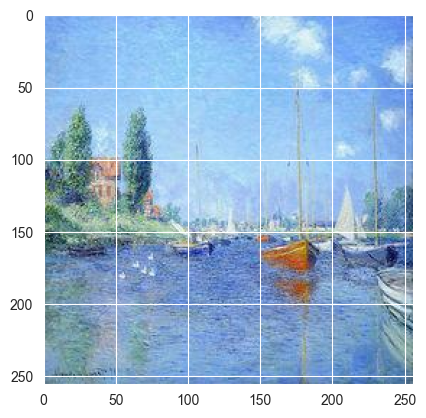

In [53]:
plt.imshow(arr, cmap='Greys_r')

In [ ]:
class Generator(nn.Module):
    def __init__(self, gen_input_dim, gen_output_dim):
        super(Generator, self).__init__()
        # self.fc1 = nn.Linear(gen_input_dim, 256)
        # self.fc2 = nn.Linear(256, 512)
        self.fc1 = nn.Linear(gen_input_dim, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, gen_output_dim)

    # forward method
    def forward(self, x):
        # x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        return torch.tanh(self.fc3(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    # forward method
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# TODO sort out dimensions
generator = Generator(gen_input_dim = IMG_SIZE, gen_output_dim = 28*28*1).to(device)
discriminator = Discriminator(28*28*1).to(device)

In [ ]:
# TODO change
# loss
criterion = nn.BCELoss()
# optimizer
optimizer_gen = optim.Adam(generator.parameters(), lr = 0.0001)
optimizer_disc = optim.Adam(discriminator.parameters(), lr = 0.0001)

In [54]:
def label_real(b_size = BATCH_SIZE):
    data = torch.ones(b_size, 1)
    return data.to(device)

def label_fake(b_size = BATCH_SIZE):
    data = torch.zeros(b_size, 1)
    return data.to(device)

In [ ]:
def train_discriminator(data_real,
                        labels,
                        data_fake,
                        generator = generator,
                        discriminator = discriminator,
                        optimizer = optimizer_disc,
                        batch_size = BATCH_SIZE
                        ):

    optimizer.zero_grad()
    discriminator.train()

    ones = label_real(data_real.shape[0])
    zeros = label_fake(data_real.shape[0])

    output_real = discriminator(data_real, labels)
    loss_real = criterion(output_real, ones)

    output_fake = discriminator(data_fake, torch.randint(0, 10, (image.shape[0], )).to(device))
    loss_fake = criterion(output_fake, zeros)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

In [ ]:
def train_generator(data_fake,
                    labels = torch.randint(0, 10, (128, )).to(device),
                    generator = generator,
                    discriminator = discriminator,
                    optimizer = optimizer_gen,
                    batch_size = BATCH_SIZE
                    ):

    optimizer.zero_grad()
    generator.train()

    ones = label_real(data_fake.shape[0])

    output = discriminator(data_fake, labels)
    loss = criterion(output, ones)

    loss.backward()
    optimizer.step()

    return loss

In [ ]:
loss_gen = []
loss_disc = []

for epoch in range(1, EPOCH_COUNT+1):

    print(f"Epoch #{epoch}")

    loss_g = 0.0
    loss_d = 0.0

    for image, _ in orig_dataloader:
        image = image.to(device)

        # run the discriminator for k number of steps
        for step in range(1):
            data_fake = generator(image).detach()
            # data_fake = generator(create_noise(image.shape[0], noise_dim)).detach()
            data_real = image

            # train the discriminator network
            loss_d += train_discriminator(data_real, data_fake)
        # data_fake = generator(create_noise(image.shape[0], noise_dim))
        # TODO why is generate here 2 times?
        data_fake = generator(image)

        # train the generator network
        loss_g += train_generator(data_fake,)

    loss_gen.append(loss_g.item())
    loss_disc.append(loss_d.item())